In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from sklearn.model_selection import train_test_split

def load_and_split_data(json_file):
    """Function to split the data into train, validation, and test"""
    with open(json_file, 'r') as file:
        data = json.load(file)

    train_data, temp_data = train_test_split(data, test_size=0.3)
    val_data, test_data = train_test_split(temp_data, test_size=0.5)
    return train_data, val_data, test_data

train_data, val_data, test_data = load_and_split_data('drive/MyDrive/combined_file40kplus_withoutcodesearch.json')


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence

class TextCodeDataset(Dataset):
    """Custom class to initialize datasets , pad sequences and truncating to max_length"""

    def __init__(self, data):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        code = self.data[idx]['code']
        # Truncate the sequences to a maximum length
        encoded_text = self.tokenizer.encode(text, add_special_tokens=True, max_length=64, truncation=True)
        encoded_code = self.tokenizer.encode(code, add_special_tokens=True, max_length=64, truncation=True)
        return torch.tensor(encoded_text), torch.tensor(encoded_code)

    def collate_fn(self, batch):
        texts, codes = zip(*batch)
        texts_padded = pad_sequence(texts, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        codes_padded = pad_sequence(codes, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        return texts_padded, codes_padded

train_dataset = TextCodeDataset(train_data)
val_dataset = TextCodeDataset(val_data)
test_dataset = TextCodeDataset(test_data)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

#Seq2Seq model to convert text to code using LSTM and a linear layer
class LSTMTextToCode(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, n_layers=2):
        super(LSTMTextToCode, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

vocab_size = len(train_dataset.tokenizer)
model = LSTMTextToCode(vocab_size)


In [ ]:
# Checking if a CUDA-enabled GPU is available, if not, using the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Moving the model to the specified device (CUDA GPU or CPU)
model.to(device)

# We can see the architecture of Code T5 - base in the output

LSTMTextToCode(
  (embedding): Embedding(30522, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=30522, bias=True)
)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

def train(model, train_dataset, val_dataset, epochs=3, batch_size=32):
    # Move model to device for faster calculations
    model.to(device)

    # Maintaining the learning rate at 5e-5
    optimizer = Adam(model.parameters(), lr=5e-5)
    loss_function = nn.CrossEntropyLoss(ignore_index=train_dataset.tokenizer.pad_token_id)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        for text, code in DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn):
            text, code = text.to(device), code.to(device)

            optimizer.zero_grad()
            output, _ = model(text)
            output = output.view(-1, output.size(-1))
            code = code.view(-1)
            loss = loss_function(output, code)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataset)
        print(f'Epoch {epoch+1}, Average Training Loss: {avg_train_loss}')

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for text, code in DataLoader(val_dataset, batch_size=batch_size, collate_fn=val_dataset.collate_fn):
                text, code = text.to(device), code.to(device)
                output, _ = model(text)
                output = output.view(-1, output.size(-1))
                code = code.view(-1)
                loss = loss_function(output, code)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataset)
        print(f'Epoch {epoch+1}, Average Validation Loss: {avg_val_loss}')

# Training the model
train(model, train_dataset, val_dataset)


Training on device: cuda
Epoch 1, Average Training Loss: 0.1862439682544506
Epoch 1, Average Validation Loss: 0.17361353777037666
Epoch 2, Average Training Loss: 0.1711459659237389
Epoch 2, Average Validation Loss: 0.16883745743468206
Epoch 3, Average Training Loss: 0.16636902842601217
Epoch 3, Average Validation Loss: 0.16516916964759673


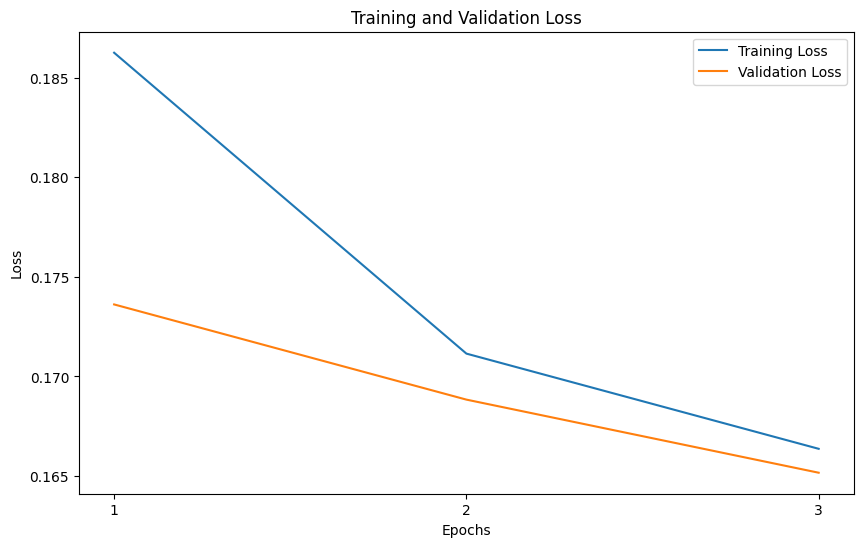

In [ ]:
# Creating a graph of training and validation loss

training_losses = [0.1862439682544506, 0.1711459659237389, 0.16636902842601217]  # Replace with your actual training loss values
validation_losses = [0.17361353777037666, 0.16883745743468206, 0.16516916964759673]  # Replace with your actual validation loss values
epochs = range(1, len(training_losses) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')

plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import torch
from nltk.translate.bleu_score import sentence_bleu
from torch.utils.data import DataLoader

def generate_code(model, tokenizer, input_text, device, max_length=64):
    """Function to generate code from text"""

    model.eval()
    input_ids = tokenizer.encode(input_text, add_special_tokens=True)
    input_tensor = torch.tensor([input_ids]).to(device)

    generated_code = []
    hidden = None
    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(input_tensor, hidden)
            predicted_token_id = output[:, -1, :].argmax(dim=1).item()
            generated_code.append(predicted_token_id)

            if predicted_token_id == tokenizer.eos_token_id:
                break

            input_tensor = torch.tensor([[predicted_token_id]]).to(device)

    return tokenizer.decode(generated_code, skip_special_tokens=True)

def evaluate_bleu_score(model, test_dataset):
    """Function to evaluate the model"""

    bleu_scores = []
    for text, true_code in DataLoader(test_dataset, batch_size=1, collate_fn=test_dataset.collate_fn):
        # Move text to the same device as the model
        text = text.to(device)
        true_code_text = tokenizer.decode(true_code[0].cpu().tolist(), skip_special_tokens=True)
        generated_code_text = generate_code(model, tokenizer, text[0].tolist(), device)
        reference = [true_code_text.split()]
        candidate = generated_code_text.split()
        score = sentence_bleu(reference, candidate)
        bleu_scores.append(score)

    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score

average_bleu_score = evaluate_bleu_score(model, test_dataset)
print(f'Average BLEU Score: {average_bleu_score}')


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU Score: 0.0026143497050426234


## This is our baseline Seq2Seq model for Text to Code generation on the same dataset of 40k+ records we used  in our final model with a Sentence BLEU score of 0.26%